In [31]:
import sys
import numpy as np
sys.path.append('..')
%load_ext autoreload
%autoreload 2

# jax config
from jax import config
config.update("jax_enable_x64", True)

# plotting
import matplotlib.pyplot as plt
import numpy as np
from opentn.utils import set_discrete_labels
from opentn.transformations import create_kitaev_liouvillians, create_trotter_layers, super2ortho

# structure preserving methods
from opentn.structure_preserving import unnormalized_scheme

# optimization
from opentn.optimization import frobenius_norm, model_stiefel_local, get_kitaev_trotter_local_ansatz

# stiefel
from opentn.stiefel import gradient_stiefel_vec, riemannian_hessian_vec, retract_stiefel
from opentn.trust_region_rcopt import riemannian_trust_region_optimize

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# TODO: move this to a unittest
from opentn.transformations import kraus2choi, choi2super, kraus2superop
A = np.random.rand(2,2)
B = np.random.rand(2,2)
kraus_list = [A, B]
op1 = choi2super(kraus2choi(kraus_list=kraus_list))
op2 = kraus2superop(kraus_list=kraus_list)
np.allclose(op1, op2)

True

# Let's do the same comparison for the kitaev wire. Let's say with $\tau = 1$ for now!

In [3]:
d, N, gamma = 2, 4, 1
Lvec, Lvec_odd, Lvec_even, Lnn = create_kitaev_liouvillians(N=N, d=d, gamma=gamma, pbc=True)

In [395]:
# testing the individual parts to see what is going on
from opentn.structure_preserving import effective_hamiltonian, composition, unnormalized_scheme_error
from opentn.transformations import super2choi
from opentn.stiefel import is_hermitian, is_isometry_2


h_eff = effective_hamiltonian(lindbladians=Lnn, N=N, d=d, pbc=True)
print(is_hermitian(h_eff)) # but when taking away the 1/j it is hermitian as expected.

# lets evaluate the conditions of the final superoperator
superop_unnormalized = unnormalized_scheme(lindbladians=Lnn, N=N, d=d, dt=1/1, order=1, quadrature='midpoint')
ortho = super2ortho(superop_unnormalized.real)
is_isometry_2(ortho)

(False, 1.3228756555322954)


False

In [409]:
superop_unnormalized_order_3 = unnormalized_scheme(lindbladians=Lnn, N=N, d=d, dt=1/1, order=3)
superop_unnormalized_order_3


[0.5] 1
[0.5, 0.5] 2


DeviceArray([[1.        +0.j, 0.        +0.j, 0.        +0.j, ...,
              0.        +0.j, 0.        +0.j, 0.        +0.j],
             [0.        +0.j, 0.88590495+0.j, 0.05533854+0.j, ...,
              0.        +0.j, 0.        +0.j, 0.        +0.j],
             [0.        +0.j, 0.05533854+0.j, 0.88590495+0.j, ...,
              0.        +0.j, 0.        +0.j, 0.        +0.j],
             ...,
             [0.        +0.j, 0.        +0.j, 0.        +0.j, ...,
              0.88590495+0.j, 0.05533854+0.j, 0.        +0.j],
             [0.        +0.j, 0.        +0.j, 0.        +0.j, ...,
              0.05533854+0.j, 0.88590495+0.j, 0.        +0.j],
             [0.        +0.j, 0.        +0.j, 0.        +0.j, ...,
              0.        +0.j, 0.        +0.j, 1.        +0.j]],            dtype=complex128)

In [407]:
from opentn.structure_preserving import m_order_f_operator
rj_expanded = [0.5]
m_order_f_operator(midpoints=rj_expanded, dt=1, m=1, M=3, lindbladians=Lnn, N=N, d=d)

1 0.5


DeviceArray([[0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
             [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
             [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
             ...,
             [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
             [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
             [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j]],            dtype=complex128)

In [192]:
np.linalg.norm(ortho.conj().T@ortho - np.eye(ortho.shape[1])) 
# also expected since it is an unormalized scheme
choi = super2choi(superop_unnormalized.real)
print(np.linalg.matrix_rank(choi))
np.linalg.eigvals(choi)[:8] # h at the end if this is hermitian
# TODO: also just if the choi matrix is hermitian

5


array([ 1.24375000e+01+0.j,  1.50000000e+00+0.j,  1.00000000e+00+0.j,
        5.00000000e-01+0.j,  1.00000000e+00+0.j,  5.25561615e-16+0.j,
       -1.81128360e-16+0.j, -2.47884975e-16+0.j])

In [425]:
tau = 1
number_timesteps = list(range(1,20))
timesteps = [tau/n for n in number_timesteps]
error_order_1 = [unnormalized_scheme_error(Lvec, Lnn, N, d, tau=tau, n=n, order=1) for n in number_timesteps]
error_order_2 = [unnormalized_scheme_error(Lvec, Lnn, N, d, tau=tau, n=n, order=2) for n in number_timesteps]
error_order_3 = [unnormalized_scheme_error(Lvec, Lnn, N, d, tau=tau, n=n, order=3, verbose=True) for n in number_timesteps]

currently using tau=1, n=1, M=3
currently using tau=1, n=2, M=3
currently using tau=1, n=3, M=3
currently using tau=1, n=4, M=3
currently using tau=1, n=5, M=3
currently using tau=1, n=6, M=3
currently using tau=1, n=7, M=3
currently using tau=1, n=8, M=3
currently using tau=1, n=9, M=3
currently using tau=1, n=10, M=3
currently using tau=1, n=11, M=3
currently using tau=1, n=12, M=3
currently using tau=1, n=13, M=3
currently using tau=1, n=14, M=3
currently using tau=1, n=15, M=3
currently using tau=1, n=16, M=3
currently using tau=1, n=17, M=3
currently using tau=1, n=18, M=3
currently using tau=1, n=19, M=3


In [423]:
taus = np.logspace(start=2, stop=-9, num=12, base=2)[::-1]
error_order_1_taus = [unnormalized_scheme_error(Lvec, Lnn, N, d, tau=tau, n=1, order=1) for tau in taus]
error_order_2_taus = [unnormalized_scheme_error(Lvec, Lnn, N, d, tau=tau, n=1, order=2) for tau in taus]
error_order_3_taus = [unnormalized_scheme_error(Lvec, Lnn, N, d, tau=tau, n=1, order=3, verbose=True) for tau in taus[5:]]

currently using tau=0.0625, n=1, M=3
currently using tau=0.125, n=1, M=3
currently using tau=0.25, n=1, M=3
currently using tau=0.5, n=1, M=3
currently using tau=1.0, n=1, M=3
currently using tau=2.0, n=1, M=3
currently using tau=4.0, n=1, M=3


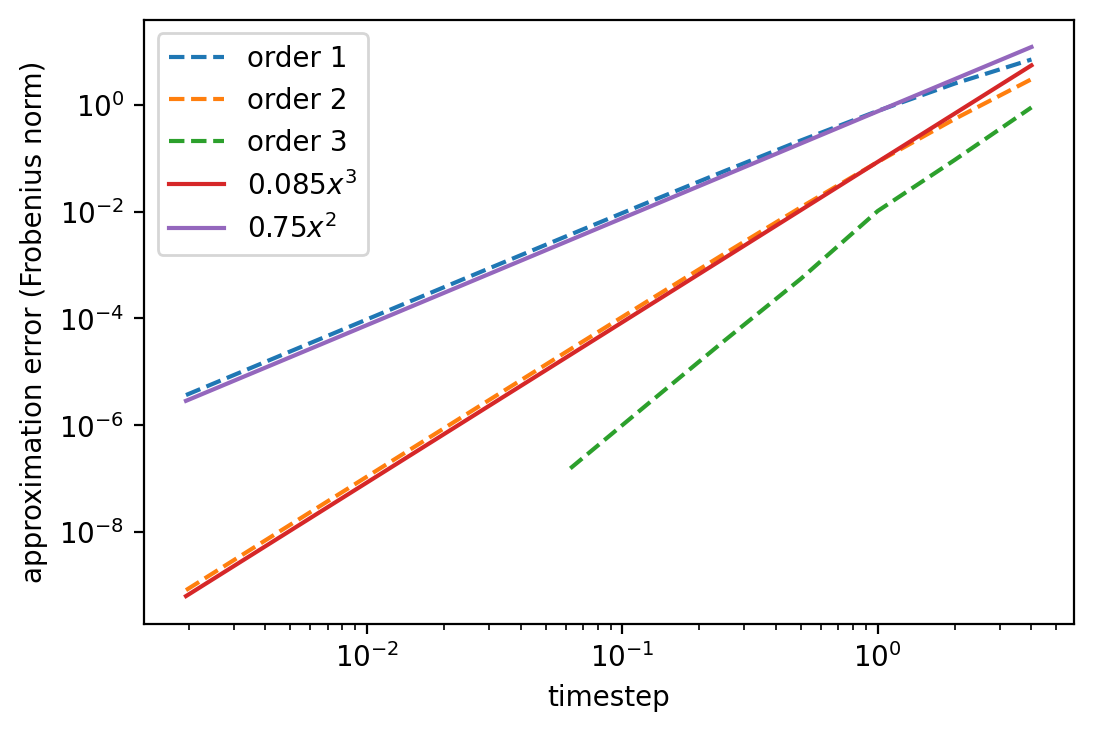

In [424]:
a  = 0.085
exponent = 3

b = 0.75
exponent_2 = 2
fig = plt.figure(dpi=200)
plt.ylabel('approximation error (Frobenius norm)')
plt.xlabel('timestep')
plt.loglog(taus, error_order_1_taus, '--', label='order 1')
plt.loglog(taus, error_order_2_taus, '--', label='order 2')
plt.loglog(taus[5:], error_order_3_taus, '--', label='order 3')
plt.loglog(taus, a*np.array(taus, dtype=float)**(exponent), label=fr'${a} x^{exponent}$')
plt.loglog(taus, b*np.array(taus, dtype=float)**(exponent_2), label=fr'${b} x^{exponent_2}$')
plt.legend()

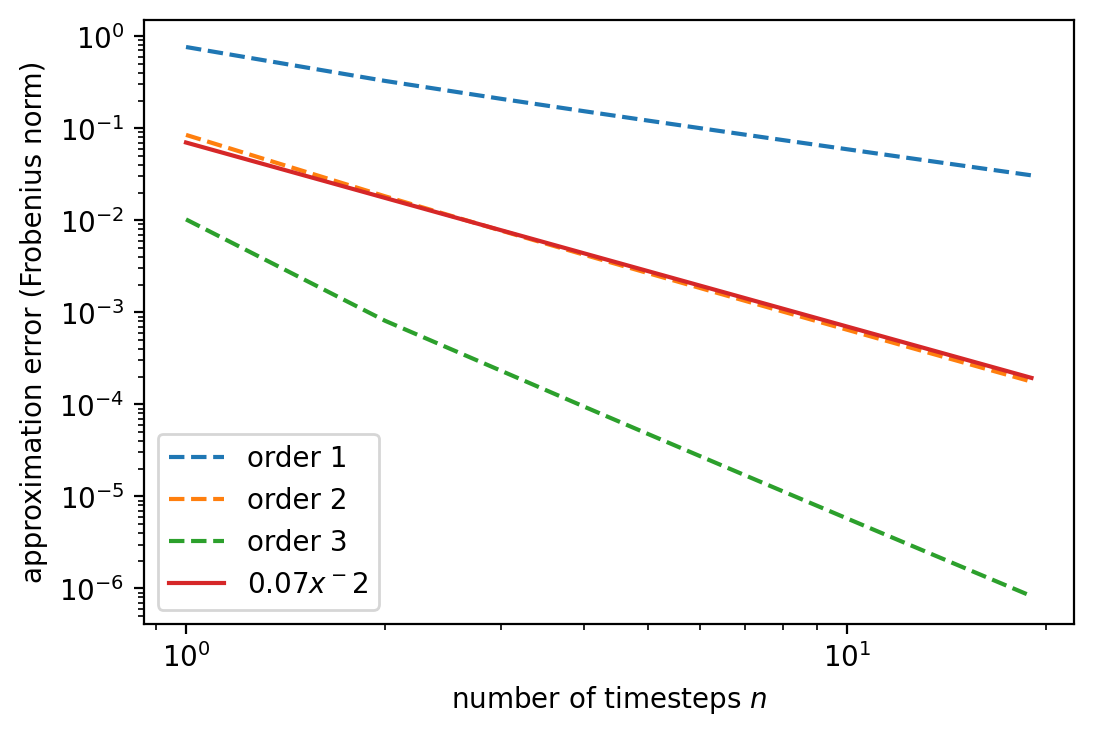

In [467]:
fig = plt.figure(dpi=200)
a = 0.07
exponent = -2
plt.ylabel('approximation error (Frobenius norm)')
plt.xlabel('number of timesteps $n$')
plt.loglog(number_timesteps, error_order_1, '--', label='order 1')
plt.loglog(number_timesteps, error_order_2, '--', label='order 2')
plt.loglog(number_timesteps, error_order_3, '--', label='order 3')
plt.loglog(number_timesteps, a*np.array(number_timesteps, dtype=float)**(exponent), label=fr'${a} x^{exponent}$')
plt.legend()

# Comparing with the stiefel optimized

In [342]:
exp_Lvec, exp_Lvec_odd, exp_Lvec_even = create_trotter_layers([Lvec, Lvec_odd, Lvec_even], tau=tau)
f_stiefel = lambda xi: frobenius_norm(model_stiefel_local(xi, N, d, ), exp_Lvec)
grad_stiefel = lambda xi: gradient_stiefel_vec(xi, f_stiefel, metric='canonical')
hessian_stiefel = lambda xi: riemannian_hessian_vec(xi, f_stiefel, metric='canonical')

In [32]:
xs_timestep_1_tau_1 = [super2ortho(x.real, rank=2) for x in get_kitaev_trotter_local_ansatz(gamma, tau, n=1)]
xs_timestep_1_tau_1_opt, f_timestep_1_tau_1_opt, radius_timestep_1_tau_1_opt = riemannian_trust_region_optimize(
    f_stiefel, retract_stiefel, grad_stiefel, hessian_stiefel, xs_timestep_1_tau_1, save_x=True, niter=10
)

iteration: 0
column : 0
column : 1
column : 2
cost function: 0.005992052805370799
radius 0.01
iteration: 1
column : 0
column : 1
column : 2
cost function: 0.005179546089593455
radius 0.01
iteration: 2
column : 0
column : 1
column : 2
cost function: 0.004968869961170965
radius 0.01
iteration: 3
column : 0
column : 1
column : 2
cost function: 0.00496715711712558
radius 0.01
iteration: 4
column : 0
column : 1
column : 2
cost function: 0.004967157113909462
radius 0.01
iteration: 5
column : 0
column : 1
column : 2
cost function: 0.00496715711390933
radius 0.0025
iteration: 6
column : 0
column : 1
column : 2
cost function: 0.00496715711390933
radius 0.000625
iteration: 7
column : 0
column : 1
column : 2
cost function: 0.00496715711390933
radius 0.00015625
iteration: 8
column : 0
column : 1
column : 2
cost function: 0.00496715711390933
radius 3.90625e-05
iteration: 9
column : 0
column : 1
column : 2
cost function: 0.00496715711390933
radius 9.765625e-06


In [33]:
xs_timestep_2_tau_1 = [super2ortho(x.real, rank=2) for x in get_kitaev_trotter_local_ansatz(gamma, tau, n=2)]
xs_timestep_2_tau_1_opt, f_timestep_2_tau_1_opt, radius_timestep_2_tau_1_opt = riemannian_trust_region_optimize(
    f_stiefel, retract_stiefel, grad_stiefel, hessian_stiefel, xs_timestep_2_tau_1, save_x=True, niter=20)

iteration: 0
column : 0
column : 1
column : 2
column : 3
column : 4
cost function: 0.0015003228414415567
radius 0.0025
iteration: 1
column : 0
column : 1
column : 2
column : 3
column : 4
cost function: 0.0015003228414415567
radius 0.0025
iteration: 2
column : 0
column : 1
column : 2
column : 3
column : 4
cost function: 0.0012899560077915995
radius 0.005
iteration: 3
column : 0
column : 1
column : 2
column : 3
column : 4
cost function: 0.0011963353491286884
radius 0.01
iteration: 4
column : 0
column : 1
column : 2
column : 3
column : 4
cost function: 0.0011472388051221108
radius 0.0025
iteration: 5
column : 0
column : 1
column : 2
column : 3
column : 4
cost function: 0.0011472388051221108
radius 0.005
iteration: 6
column : 0
column : 1
column : 2
column : 3
column : 4
cost function: 0.0010822344505412636
radius 0.005
iteration: 7
column : 0
column : 1
column : 2
column : 3
column : 4
cost function: 0.0010526946205771715
radius 0.005
iteration: 8
column : 0
column : 1
column : 2
column :

In [34]:
xs_timestep_3_tau_1 = [super2ortho(x.real, rank=2) for x in get_kitaev_trotter_local_ansatz(gamma, tau, n=3)]
xs_timestep_3_tau_1_opt, f_timestep_3_tau_1_opt, radius_timestep_3_tau_1_opt = riemannian_trust_region_optimize(
    f_stiefel, retract_stiefel, grad_stiefel, hessian_stiefel, xs_timestep_3_tau_1, save_x=True, niter=20)

iteration: 0
column : 0
column : 1
column : 2
column : 3
column : 4
column : 5
column : 6
cost function: 0.0006670002231771639
radius 0.0025
iteration: 1
column : 0
column : 1
column : 2
column : 3
column : 4
column : 5
column : 6
cost function: 0.0006670002231771639
radius 0.0025
iteration: 2
column : 0
column : 1
column : 2
column : 3
column : 4
column : 5
column : 6
cost function: 0.0005597474477551285
radius 0.0025
iteration: 3
column : 0
column : 1
column : 2
column : 3
column : 4
column : 5
column : 6
cost function: 0.0005060980689836066
radius 0.005
iteration: 4
column : 0
column : 1
column : 2
column : 3
column : 4
column : 5
column : 6
cost function: 0.0004657673579950943
radius 0.005
iteration: 5
column : 0
column : 1
column : 2
column : 3
column : 4
column : 5
column : 6
cost function: 0.0004484933170580338
radius 0.01
iteration: 6
column : 0
column : 1
column : 2
column : 3
column : 4
column : 5
column : 6
cost function: 0.0003786516418230549
radius 0.0025
iteration: 7
colu

In [339]:
xs_timestep_4_tau_1 = [super2ortho(x.real, rank=2) for x in get_kitaev_trotter_local_ansatz(gamma, tau, n=4)]
xs_timestep_4_tau_1_opt, f_timestep_4_tau_1_opt, radius_timestep_4_tau_1_opt = riemannian_trust_region_optimize(
    f_stiefel, retract_stiefel, grad_stiefel, hessian_stiefel, xs_timestep_4_tau_1, save_x=True, niter=40)

iteration: 0
column : 0
column : 1
column : 2
column : 3
column : 4
column : 5
column : 6
column : 7
column : 8
cost function: 0.000375225044875735
radius 0.0025
iteration: 1
column : 0
column : 1
column : 2
column : 3
column : 4
column : 5
column : 6
column : 7
column : 8
cost function: 0.000375225044875735
radius 0.0025
iteration: 2
column : 0
column : 1
column : 2
column : 3
column : 4
column : 5
column : 6
column : 7
column : 8
cost function: 0.00031554533579632415
radius 0.0025
iteration: 3
column : 0
column : 1
column : 2
column : 3
column : 4
column : 5
column : 6
column : 7
column : 8
cost function: 0.0002746439079787677
radius 0.0025
iteration: 4
column : 0
column : 1
column : 2
column : 3
column : 4
column : 5
column : 6
column : 7
column : 8
cost function: 0.00023536959437316313
radius 0.005
iteration: 5
column : 0
column : 1
column : 2
column : 3
column : 4
column : 5
column : 6
column : 7
column : 8
cost function: 0.0002068539964610864
radius 0.00125
iteration: 6
column : 

In [324]:
xs_timestep_5_tau_1 = [super2ortho(x.real, rank=2) for x in get_kitaev_trotter_local_ansatz(gamma, tau, n=5)]
xs_timestep_5_tau_1_opt, f_timestep_5_tau_1_opt, radius_timestep_5_tau_1_opt = riemannian_trust_region_optimize(
    f_stiefel, retract_stiefel, grad_stiefel, hessian_stiefel, xs_timestep_5_tau_1, save_x=True, niter=20)

iteration: 0
column : 0
column : 1
column : 2
column : 3
column : 4
column : 5
column : 6
column : 7
column : 8
column : 9
column : 10
cost function: 0.0002401551132857103
radius 0.0025
iteration: 1
column : 0
column : 1
column : 2
column : 3
column : 4
column : 5
column : 6
column : 7
column : 8
column : 9
column : 10
cost function: 0.0002401551132857103
radius 0.0025
iteration: 2
column : 0
column : 1
column : 2
column : 3
column : 4
column : 5
column : 6
column : 7
column : 8
column : 9
column : 10
cost function: 0.00019529293289439348
radius 0.0025
iteration: 3
column : 0
column : 1
column : 2
column : 3
column : 4
column : 5
column : 6
column : 7
column : 8
column : 9
column : 10
cost function: 0.00016495851052516654
radius 0.0025
iteration: 4
column : 0
column : 1
column : 2
column : 3
column : 4
column : 5
column : 6
column : 7
column : 8
column : 9
column : 10
cost function: 0.00013893188876613798
radius 0.0025
iteration: 5
column : 0
column : 1
column : 2
column : 3
column : 4

In [465]:
f_stiefel_ts = [f_timestep_1_tau_1_opt, f_timestep_2_tau_1_opt, f_timestep_3_tau_1_opt, f_timestep_4_tau_1_opt, f_timestep_5_tau_1_opt]
error_nonoptimized_tau_1 = [values[0] for values in f_stiefel_ts]
error_stiefel_tau_1 = [values[-1] for values in f_stiefel_ts]

In [473]:
len(f_timestep_4_tau_1_opt), len(f_timestep_5_tau_1_opt)

(26, 20)

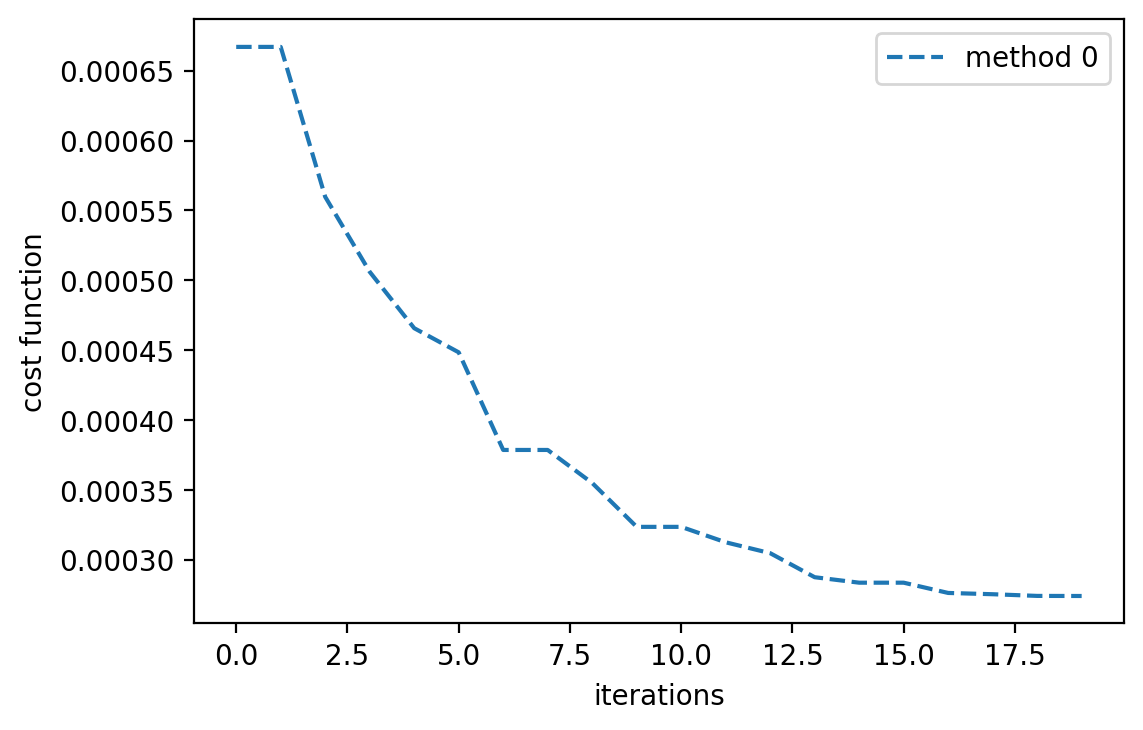

In [477]:
from opentn.utils import plot_cost_function_vs_iter
plot_cost_function_vs_iter(cost_list=f_timestep_3_tau_1_opt)

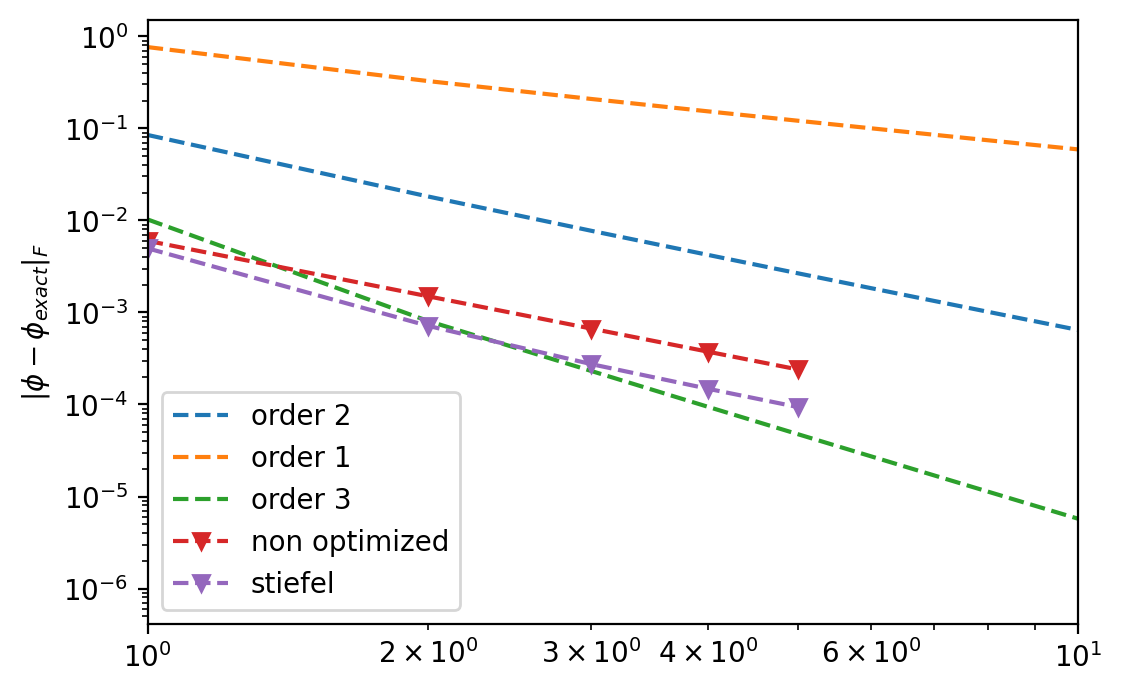

In [488]:
number_timesteps_stiefel = [1,2,3,4,5]
timesteps_stiefel = [tau/n for n in number_timesteps_stiefel]

fig = plt.figure(dpi=200)
plt.ylabel(r'$ \left| \phi - \phi_{exact} \right|_F $')
ax = plt.gca()
# plt.xlabel('timestep')
plt.xlim(1,10)

plt.loglog(number_timesteps, error_order_2, '--', label='order 2')
plt.loglog(number_timesteps, error_order_1, '--', label='order 1')
plt.loglog(number_timesteps, error_order_3, '--', label='order 3')

plt.loglog(number_timesteps_stiefel, error_nonoptimized_tau_1, '--v', label='non optimized')
exponent = -2
a = 0.006
# plt.loglog(number_timesteps_stiefel, a*np.array(number_timesteps_stiefel, dtype=float)**(exponent), '-*' ,label=fr'${a} x^{exponent}$')

plt.loglog(number_timesteps_stiefel, error_stiefel_tau_1, '--v', label='stiefel')
exponent_2 = -2.6
b = 0.005
# plt.loglog(number_timesteps_stiefel, b*np.array(number_timesteps_stiefel, dtype=float)**(exponent_2), '-*' ,label=fr'${b} x^{exponent_2}$')

plt.legend()

# Create random psd and use to compare the schemes

In [317]:
from opentn.stiefel import random_psd
from opentn.transformations import vectorize, unvectorize
from opentn.optimization import get_general_trotter_local_ansatz
from opentn.structure_preserving import random_psd_error, compute_trace_superop


In [431]:
num_timesteps_scheme = 20
superop_nonopt_ts = []
for n in range(1, num_timesteps_scheme + 1):
    xs_trotter_ts = [super2ortho(op) for op in get_general_trotter_local_ansatz(lindbladians=Lnn, tau=tau, n=n)]
    superop_nonopt_ts.append(model_stiefel_local(xs_trotter_ts, N, d))

xs_stiefel_ts = [xs_timestep_1_tau_1_opt, xs_timestep_2_tau_1_opt, xs_timestep_3_tau_1_opt, xs_timestep_4_tau_1_opt]

# stiefel optimized
superop_stiefel_ts = [model_stiefel_local(xs[-1], N, d) for xs in xs_stiefel_ts]

superop_ord_1_ts = [composition(unnormalized_scheme(lindbladians=Lnn, N=N, d=d, dt=tau/n, order=1), n=n) for n in range(1, num_timesteps_scheme + 1)]
superop_ord_2_ts = [composition(unnormalized_scheme(lindbladians=Lnn, N=N, d=d, dt=tau/n, order=2), n=n) for n in range(1, num_timesteps_scheme + 1)]
superop_ord_3_ts = [composition(unnormalized_scheme(lindbladians=Lnn, N=N, d=d, dt=tau/n, order=3, verbose=True), n=n) for n in range(1, num_timesteps_scheme + 1)]

currently using dt=1.0, M=3
currently using dt=0.5, M=3
currently using dt=0.3333333333333333, M=3
currently using dt=0.25, M=3
currently using dt=0.2, M=3
currently using dt=0.16666666666666666, M=3
currently using dt=0.14285714285714285, M=3
currently using dt=0.125, M=3
currently using dt=0.1111111111111111, M=3
currently using dt=0.1, M=3
currently using dt=0.09090909090909091, M=3
currently using dt=0.08333333333333333, M=3
currently using dt=0.07692307692307693, M=3
currently using dt=0.07142857142857142, M=3
currently using dt=0.06666666666666667, M=3
currently using dt=0.0625, M=3
currently using dt=0.058823529411764705, M=3
currently using dt=0.05555555555555555, M=3
currently using dt=0.05263157894736842, M=3
currently using dt=0.05, M=3


In [448]:
error_nonopt_unnorm = random_psd_error(superop_exact=exp_Lvec, superops_error=superop_nonopt_ts, normalize=False)
error_stiefel_unnorm = random_psd_error(superop_exact=exp_Lvec, superops_error=superop_stiefel_ts, normalize=False)

error_order_1_unnorm = random_psd_error(superop_exact=exp_Lvec, superops_error=superop_ord_1_ts, normalize=False)
error_order_2_unnorm = random_psd_error(superop_exact=exp_Lvec, superops_error=superop_ord_2_ts, normalize=False)
error_order_3_unnorm = random_psd_error(superop_exact=exp_Lvec, superops_error=superop_ord_3_ts, normalize=False)
errors_unnorm = [error_nonopt_unnorm, error_stiefel_unnorm, error_order_1_unnorm, error_order_2_unnorm, error_order_3_unnorm]

In [449]:
error_nonopt_norm = random_psd_error(superop_exact=exp_Lvec, superops_error=superop_nonopt_ts, normalize=True)
error_stiefel_norm = random_psd_error(superop_exact=exp_Lvec, superops_error=superop_stiefel_ts, normalize=True)

error_order_1_norm = random_psd_error(superop_exact=exp_Lvec, superops_error=superop_ord_1_ts, normalize=True)
error_order_2_norm = random_psd_error(superop_exact=exp_Lvec, superops_error=superop_ord_2_ts, normalize=True)
error_order_3_norm = random_psd_error(superop_exact=exp_Lvec, superops_error=superop_ord_3_ts, normalize=True)

errors_norm = [error_nonopt_norm, error_stiefel_norm, error_order_1_norm, error_order_2_norm, error_order_3_norm]

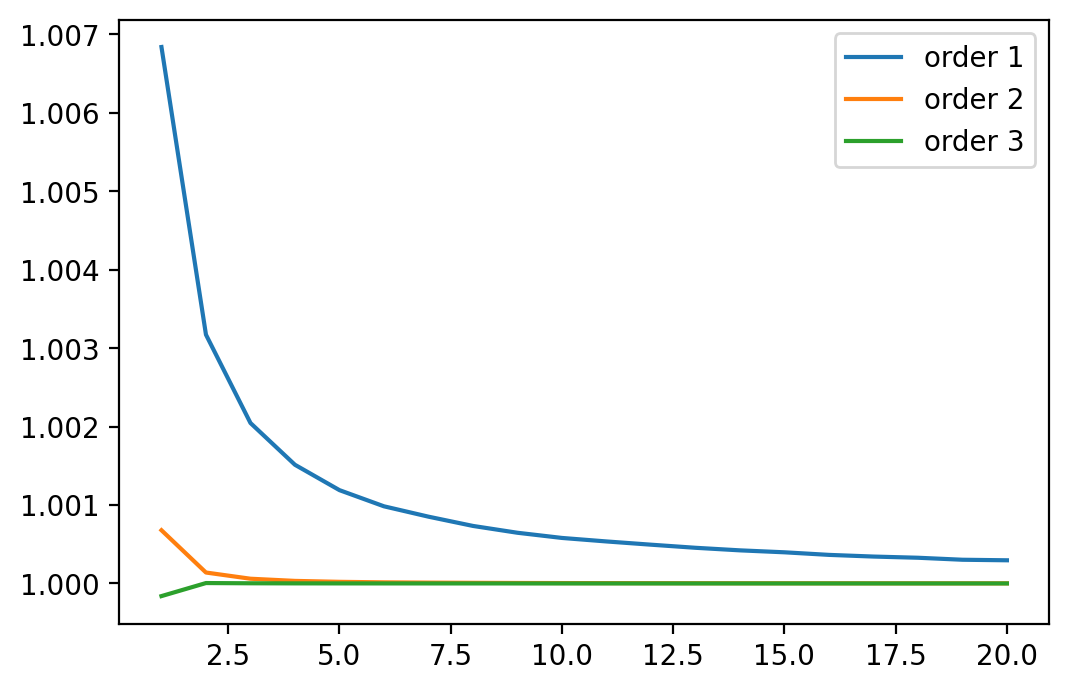

In [486]:
# testing out the traces of the unnormalized schemes
traces_ord_1 = []
traces_ord_2 = []
traces_ord_3 = []

for superop in superop_ord_1_ts:
    traces_ord_1.append(compute_trace_superop(superop))

for superop in superop_ord_2_ts:
    traces_ord_2.append(compute_trace_superop(superop))

for superop in superop_ord_3_ts:
    traces_ord_3.append(compute_trace_superop(superop))
    
fig = plt.figure(dpi=200)
plt.plot(range(1, len(traces_ord_1) + 1), traces_ord_1, label='order 1')
plt.plot(range(1, len(traces_ord_2) + 1), traces_ord_2, label='order 2')
plt.plot(range(1, len(traces_ord_3) + 1), traces_ord_3, label='order 3')
plt.legend()

In [444]:
traces_ord_1

[(1.0062093781117143+0j),
 (1.003669763872902+0j),
 (1.0020560436257755+0j),
 (1.0015183896209443+0j),
 (1.000906277783909+0j),
 (1.0012227667007716+0j),
 (1.0009130712075556+0j),
 (1.0007616658778333+0j),
 (1.000610881439091+0j),
 (1.0005917164457374+0j),
 (1.0006707289886256+0j),
 (1.0004283115764925+0j),
 (1.0004396659363273+0j),
 (1.000324646851054+0j),
 (1.0003647684912844+0j),
 (1.000381185553964+0j),
 (1.0003142940228922+0j),
 (1.0003183301607965+0j),
 (1.0002762595706145+0j),
 (1.000270152291863+0j)]

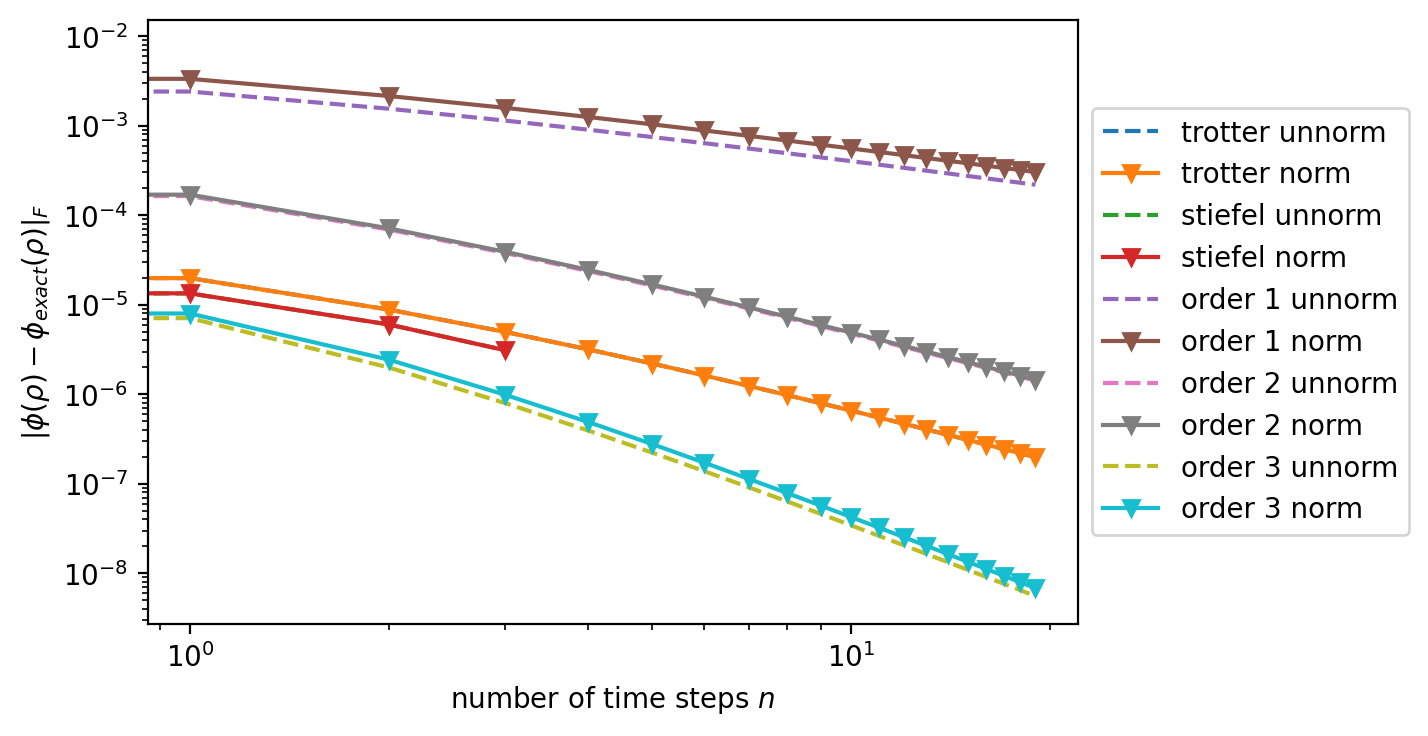

In [485]:
# without dividing by the trace
labels = ['trotter', 'stiefel', 'order 1', 'order 2', 'order 3']
fig = plt.figure(dpi=200)
plt.ylabel(r'$ \left| \phi(\rho) - \phi_{exact}(\rho) \right|_F $')
plt.xlabel('number of time steps $n$')
for i, (unnorm, norm) in enumerate(zip(errors_unnorm, errors_norm)):
    plt.loglog(unnorm, '--', label=labels[i] + ' unnorm')
    plt.loglog(norm, '-v', label=labels[i] + ' norm')
# Place the legend outside the plot
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

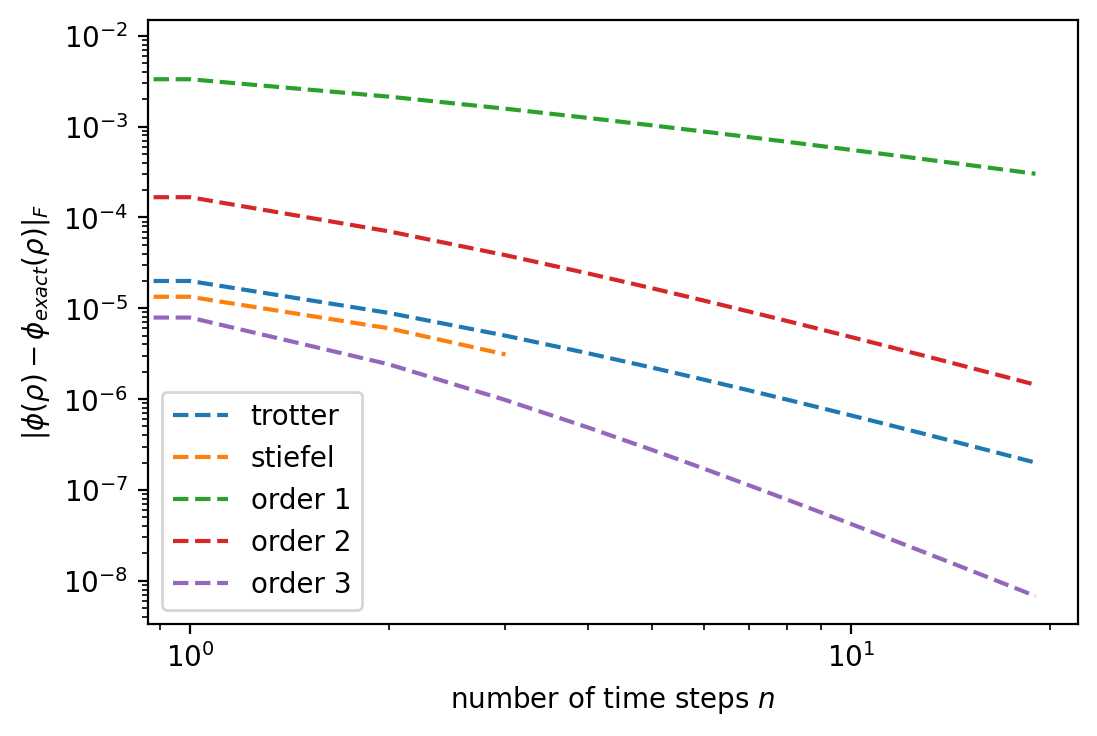

In [440]:
labels = ['trotter', 'stiefel', 'order 1', 'order 2', 'order 3']
fig = plt.figure(dpi=200)
plt.ylabel(r'$ \left| \phi(\rho) - \phi_{exact}(\rho) \right|_F $')
plt.xlabel('number of time steps $n$')
for i in range(len(errors_norm)):
    plt.loglog(errors_norm[i], '--', label=labels[i])
plt.legend()
# set_discrete_labels(labels=[str(ts+1) for ts in range(num_timesteps_scheme)], rotation=0)

In [464]:
from opentn.structure_preserving import generate_indices_ks, check_indices_ks, generate_differences, generate_rj_with_multiplicity
# Example usage:
n = 2
m = 3
ks_list = generate_indices_ks(n, m)
for ks in ks_list:
    check_indices_ks(ks, m)

# Example usage:
numbers = [0, 1, 3, 6, 10, 15]
print(generate_differences(numbers))

# generate_rj_with_multiplicity(rj_list=[1,2,3,4,5], ks=[2,3])

[1, 2, 3, 4, 5]


In [453]:
# from opentn.structure_preserving import choose_nm, generate_rj, generate_rjs_subsets

# taus = np.logspace(start=2, stop=-9, num=12, base=2)[::-1]
# print('taus: ', taus)
# for tau in taus[:]:
#     print(choose_nm(m=1, M=3, dt=tau))

# Nm = 262144
# m = 1
# dt = 1.953125e-03
# rj_all = generate_rj(Nm=Nm, dt=dt)
# for n in range(1, min(m, Nm) + 1):
#     print('n: ', n)
#     ks_list = generate_indices_ks(n=n, m=m)
#     print(ks_list)
#     rj_subsets = generate_rjs_subsets(rj_all=rj_all, n=n)
#     print('rj: ', rj_subsets)

# number_timesteps = list(range(1,20))
# tau = 1
# for n in number_timesteps:
#     print(choose_nm(m=1, M=3, dt=tau/n))